# Autoencoders and POD on flow past cylinder (FPC) dataset

Example notebook that displays the functionality of the built package for FPC and reproduces the results from the report

In [1]:
# All of the necessary external package imports
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

# Built package imports
import ddganAE
from ddganAE.utils import calc_pod
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures.cae.D2 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *
from ddganAE.preprocessing import convert_2d

In [2]:
# Setting seeds for reproduceability
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Proper Orthogonal Decomposition (POD)

First we try POD to benchmark the other models against

In [3]:
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

In [4]:
# Some data reshaping

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)

In [5]:
# Normalize data and calculate POD

# Could also try subtracting the mean but this does not give better results
layer = preprocessing.Normalization(axis=None)
layer.adapt(snapshots_grids)

snapshots_norm = layer(snapshots_grids).numpy()

coeffs, R, s = calc_pod(snapshots_norm, nPOD=10)

SSmatrix (8000, 8000)


In [6]:
# Calculate MSE
mean = 0
for j in range(4):
    recon = R @ coeffs[j]
    for i in range(2000):
        mean += tf.keras.losses.MSE(recon[:, i], snapshots_norm[j, :, i]).numpy()/8000

print("POD MSE loss of the normalized dataset's reconstruction: ", mean)

POD MSE loss of the normalized dataset's reconstruction:  0.011914519353747969


In [7]:
# Create reconstructed grids
reconstructed = np.zeros((4, 4620, 2000))

for i in range(4):
    reconstructed[i, :, :] = R @ coeffs[i]

# Undo normalization
reconstructed = (reconstructed * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())

In [8]:
# Reshape to fit in interpolation (legacy) fortran code
reconstructed = convert_2d(reconstructed, (55, 42, 2), 2000)
reconstructed = np.array(reconstructed).swapaxes(1, 4)

# Uncomment line below to save results
# np.save("reconstruction_pod_10coeffs.npy", reconstructed)

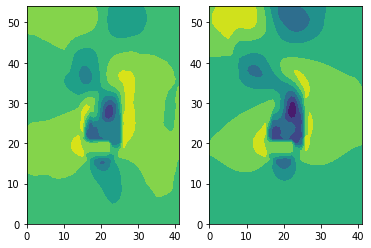

In [9]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(1,2)
ax[0].contourf(reconstructed[0, 0, :, :, 100])
ax[1].contourf(snapshots[100, :, :, 0])

## Convolutional Autoencoder

In [3]:
# This cell does preprocessing, it is the same for the CAE and the AAE

# Let's load in the data, split and reshape for the autoencoders
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Some data reshaping
input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)

# Normalize and split dataset
layer = preprocessing.Normalization()
layer.adapt(snapshots)

x_train, x_val = train_test_split(snapshots, test_size=0.1, random_state=seed)
x_train = layer(x_train)
x_val = layer(x_val)

In [5]:
## The hyperparameters set in this cell and the next correspond to the optimal hyperparameters from hyperparameter
# optimization
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Adam(lr=0.00005, beta_1=0.98, beta_2=0.9)

# Use this line to create a new model, select any from the list of models provided in the documentation or make
# your own
encoder, decoder = build_denser_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')

# Use these lines to load a previously trained model
# encoder = tf.keras.models.load_model("saved_model_cae/encoder") 
# decoder = tf.keras.models.load_model("saved_model_cae/decoder")

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape, pi_loss=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 55, 42, 32)        1632      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 21, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 11, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5376)             

In [6]:
# Tensorboard logs the results, run `tensorboard --logdir logs` in this directory in a terminal with acces to
# Tensorflow. Note that we can extract the MSE for the final report loss directly from tensorboard as the model
# evaluates the validation dataset at every epoch
cae.train(x_train, 200, val_data=x_val, batch_size=128)

In [12]:
cae.autoencoder.evaluate(x_val, x_val)[0]

25/25 [==============================] - 1s 57ms/step - loss: 0.1182 - accuracy: 0.8882


[0.11818601936101913, 0.8881969451904297]

In [13]:
# uncomment lines below to save the model
# !mkdir -p saved_model
# cae.encoder.save('saved_model/encoder')
# cae.decoder.save('saved_model/decoder')

In [14]:
# Compress all the samples
snapshots = layer(snapshots)
res = cae.predict(snapshots)

In [15]:
# Undo normalization
res = (res * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())

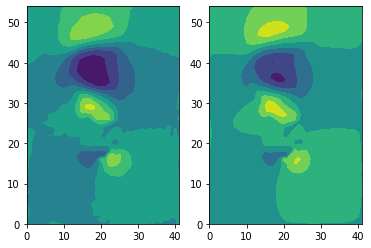

In [16]:
# Let's plot a reconstruction to see if it visually corresponds to what we expect
fig, ax = plt.subplots(1,2)
ax[0].contourf(res[92,:,:,1])
ax[1].contourf(snapshots[92, :, :, 1])

In [17]:
# Reshape to how reconstruction legacy code wants it
reconstruction = res.reshape((4, 2000, 55, 42, 2)).swapaxes(1, 4)
np.save("cae_reconstruction.npy", reconstruction)

## Adversarial Autoencoder

In [18]:
# This cell does preprocessing, it is the same for the CAE and the AAE

# Let's load in the data, split and reshape for the autoencoders
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Some data reshaping
input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)

# Normalize and split dataset
layer = preprocessing.Normalization()
layer.adapt(snapshots)

x_train, x_val = train_test_split(snapshots, test_size=0.1, random_state=seed)
x_train = layer(x_train)
x_val = layer(x_val)

In [19]:
# The hyperparameters set in this cell and the next correspond to the optimal hyperparameters from hyperparameter
# optimization
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.8, beta_2=0.9)

# Use this line to create a new model, select any from the list of models provided in the documentation or make
# your own
encoder, decoder = build_densest_omata_encoder_decoder(input_shape, 10, initializer, act='elu', dense_act='relu', info=True)
discriminator = build_custom_discriminator(10, initializer, info=True)

# Use these lines to load a previously trained model
# encoder = tf.keras.models.load_model("saved_model_aae/encoder")
# decoder = tf.keras.models.load_model("saved_model_aae/decoder")
# discriminator = tf.keras.models.load_model("saved_model_aae/discriminator")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 55, 42, 32)        1632      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 21, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9856)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 9856)              97150592  
_________________________________________________________________
dense_5 (Dense)              (None, 4928)             

### Separate losses

Adversarial autoencoder with a separate loss for the discriminator, autoencoder, and generator. Each of these three are trained separately with this method.

Execute either the following two cells or the two cells under "combined losses".

In [ ]:
aae = AAE(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

In [ ]:
aae.train(x_train, 200, val_data=x_val)

### Combined losses

Aversarial autoencoder with a combined (and weighted) loss function for the discriminator and autoencoder, the generator is still trained independently. This model tends to perform significantly better.

In [20]:
aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

In [21]:
aae.train(x_train, 200, val_data=x_val, batch_size=64)

KeyboardInterrupt: 

In [ ]:
# Calculate a loss value on the validation set
res_val = aae.adversarial_autoencoder.predict(x_val)[0]
np.mean(tf.keras.losses.MSE(res_val, x_val))

In [ ]:
snapshots = layer(snapshots)
res = aae.adversarial_autoencoder.predict(snapshots)[0]

In [ ]:
# Undo normalization
res = (res * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(res[92,:,:,1])
ax[1].contourf(snapshots[92, :, :, 1])

In [ ]:
# Reshape to fit in interpolation (legacy) fortran code
reconstruction = res.reshape((4, 2000, 55, 42, 2)).swapaxes(1, 4)
np.save("aae_reconstruction.npy", reconstruction)

## SVD Autoencoder

In [3]:
# Data preprocessing

# Load grids
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Data normalization
layer = preprocessing.Normalization(axis=None)
layer.adapt(snapshots_grids)

snapshots_grids = snapshots_grids.swapaxes(0, 2)

x_train, x_val = train_test_split(snapshots_grids, test_size=0.1)
x_train = layer(x_train).numpy().swapaxes(0, 2)
x_val = layer(x_val).numpy().swapaxes(0, 2)

In [4]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

encoder, decoder = build_vinicius_encoder_decoder(100, 10, initializer, act='elu', dense_act='relu', info=False, reg=0, dropout=0.55, batchnorm=False)

# encoder = tf.keras.models.load_model("saved_model_svdae/encoder")
# decoder = tf.keras.models.load_model("saved_model_svdae/decoder")

In [5]:
svdae = SVDAE(encoder, decoder, optimizer)
svdae.compile(100, weight_loss=False)

# Only set this when loading in the model
# svdae.R = np.load("R_svdae.npy")

In [6]:
svdae.train(x_train, 200, val_data=x_val, batch_size=64)

SSmatrix (7200, 7200)


In [9]:
# Generate a loss value and create an array of output grids
output = np.zeros((4, 2, 55, 42, 200))
loss = 0
for i in range(x_val.shape[0]):
    for j in range(x_val.shape[2]):
        original = x_val[i, :, j]
        result = svdae.predict_single(original)
        loss += tf.keras.losses.MSE(original, result)
        result = (result * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())
        result = np.expand_dims(result,(0,2))
        input_shape = (55, 42, 2)
        result = convert_2d(result, input_shape, 1)
        output[i, :, :, :, j] = np.moveaxis(np.array(result).reshape(55, 42, 2), 2, 0)
        
loss.numpy()/200

0.08573786534303246

In [ ]:
original = x_val[2, :, 30]

result = svdae.predict_single(original)
result = np.expand_dims(result,(0,2))
input_shape = (55, 42, 2)
result = convert_2d(result, input_shape, 1)

original = np.expand_dims(original,(0,2))
original = convert_2d(original, input_shape, 1)

fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])

In [ ]:
np.save("svdae_reconstruction.npy", output)

In [ ]:
!mkdir -p saved_model
svdae.encoder.save('saved_model_svdae/encoder')
svdae.decoder.save('saved_model_svdae/decoder')
np.save('saved_model_svdae/R.npy', svdae.R)